In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA


In [2]:
# Loading datasets
df_customers = pd.read_csv("C:/Users/Prasad/Downloads/Customers.csv")
df_products = pd.read_csv("C:/Users/Prasad/Downloads/Products.csv")
df_transactions = pd.read_csv("C:/Users/Prasad/Downloads/Transactions.csv")

In [3]:
df_products

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31
...,...,...,...,...
95,P096,SoundWave Headphones,Electronics,307.47
96,P097,BookWorld Cookbook,Books,319.34
97,P098,SoundWave Laptop,Electronics,299.93
98,P099,SoundWave Mystery Book,Books,354.29


In [4]:
df_customers

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15
...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07
196,C0197,Christina Harvey,Europe,2023-03-21
197,C0198,Rebecca Ray,Europe,2022-02-27
198,C0199,Andrea Jenkins,Europe,2022-12-03


In [5]:
df_transactions

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68
...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86


In [7]:
# Merge transaction data with customer information
merged_data = pd.merge(df_transactions, df_customers, on='CustomerID', how='left')

# Aggregate transaction data to summarize customer behavior
transaction_data = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    avg_purchase_value=('TotalValue', 'mean'),
    avg_quantity=('Quantity', 'mean')
).reset_index()


In [8]:
# Add recency metric based on the last transaction date
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data['Recency'] = (merged_data['TransactionDate'].max() - merged_data['TransactionDate']).dt.days
recency_data = merged_data.groupby('CustomerID')['Recency'].min().reset_index()

# Merge the recency data with the transaction features
customer_profile = pd.merge(transaction_data, recency_data, on='CustomerID')


In [9]:
# Normalize the data (important for clustering)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profile.drop('CustomerID', axis=1))


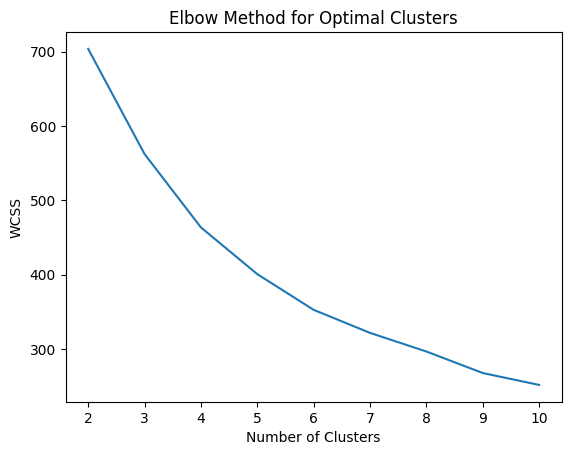

In [10]:
# Use K-Means with different cluster numbers to find the best one
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [11]:
# Fit the K-Means model with the chosen number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_data)


In [12]:
# Fit the K-Means model with the chosen number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_data)


In [13]:
# Compute the Davies-Bouldin Index (DBI)
db_index = davies_bouldin_score(scaled_data, customer_profile['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 1.0968465000822492


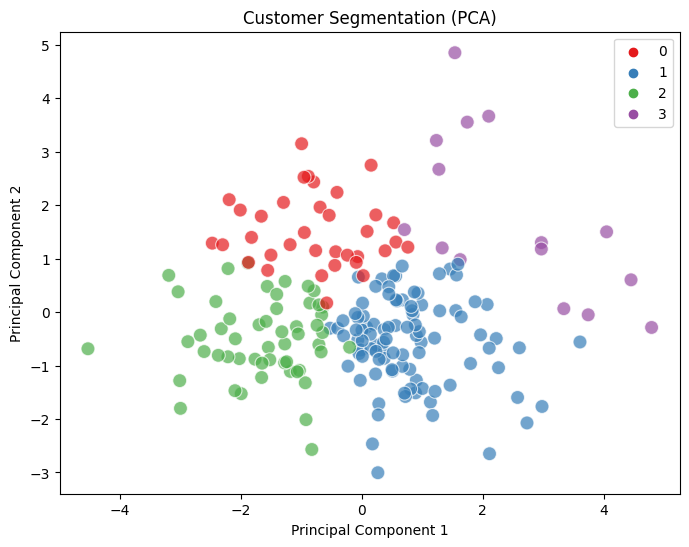

In [14]:
# Apply PCA to reduce the data to 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2D PCA components and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_profile['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segmentation (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
